In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import pickle
import warnings 
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
raw_data = pd.read_csv("Housing.csv", index_col=None)
raw_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
data = raw_data

### Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
data.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [6]:
data.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [7]:
# Check for the values in the object columns

obj_cols = data.select_dtypes(exclude=np.number).columns
for col in obj_cols:
    print(f'{data[col].value_counts()}\n\n')

mainroad
yes    468
no      77
Name: count, dtype: int64


guestroom
no     448
yes     97
Name: count, dtype: int64


basement
no     354
yes    191
Name: count, dtype: int64


hotwaterheating
no     520
yes     25
Name: count, dtype: int64


airconditioning
no     373
yes    172
Name: count, dtype: int64


prefarea
no     417
yes    128
Name: count, dtype: int64


furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64




In [8]:
# Delete the unwanted columns

data = data.drop(['stories','guestroom','prefarea'],axis=1)

In [9]:
data.head()

,price,area,bedrooms,bathrooms,mainroad,basement,hotwaterheating,airconditioning,parking,furnishingstatus
0,13300000,7420,4,2,yes,no,no,yes,2,furnished
1,12250000,8960,4,4,yes,no,no,yes,3,furnished
2,12250000,9960,3,2,yes,yes,no,no,2,semi-furnished
3,12215000,7500,4,2,yes,yes,no,yes,3,furnished
4,11410000,7420,4,1,yes,yes,no,yes,2,furnished


In [10]:
data = pd.get_dummies(data,dtype=int,drop_first=True)
data.head()

,price,area,bedrooms,bathrooms,parking,mainroad_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,2,1,0,0,1,0,0
1,12250000,8960,4,4,3,1,0,0,1,0,0
2,12250000,9960,3,2,2,1,1,0,0,1,0
3,12215000,7500,4,2,3,1,1,0,1,0,0
4,11410000,7420,4,1,2,1,1,0,1,0,0


In [11]:
data.shape

(545, 11)

In [12]:
data[['price','area']].describe()

,price,area
count,5.450000e+02,545.000000
mean,4.766729e+06,5150.541284
std,1.870440e+06,2170.141023
min,1.750000e+06,1650.000000
25%,3.430000e+06,3600.000000
50%,4.340000e+06,4600.000000
75%,5.740000e+06,6360.000000
max,1.330000e+07,16200.000000


In [13]:
data = data.astype('int64')

In [14]:
data.dtypes

price                              int64
area                               int64
bedrooms                           int64
bathrooms                          int64
parking                            int64
mainroad_yes                       int64
basement_yes                       int64
hotwaterheating_yes                int64
airconditioning_yes                int64
furnishingstatus_semi-furnished    int64
furnishingstatus_unfurnished       int64
dtype: object

In [15]:
data.duplicated().any()

False

## Expoloratory Data Analysis

### 1. Describe the univariate Analysis of Price Variable ?

In [16]:
data_univariate = pd.DataFrame(index=['Mean','Median','Mode','Q1:25%','Q2:50%','Q3:75%','99%','Q4:100%','IQR','1.5-Rule',
                           'Lesser Outlier','Greater Outlier','Min','Max','Skew','Kurtosis','Variance','STD'], columns = data.columns)

In [17]:
for column in data.columns:
    data_univariate[column]['Mean'] = data[column].mean()
    data_univariate[column]['Median'] = data[column].median()
    data_univariate[column]['Mode'] = data[column].mode()[0]
    data_univariate[column]['Q1:25%'] = data.describe()[column]['25%']
    data_univariate[column]['Q2:50%'] = data.describe()[column]['50%']
    data_univariate[column]['Q3:75%'] = data.describe()[column]['75%']
    data_univariate[column]['99%'] = np.percentile(data[column],99)
    data_univariate[column]['Q4:100%'] = data.describe()[column]['max']
    data_univariate[column]['IQR'] = data_univariate[column]['Q3:75%'] - data_univariate[column]['Q1:25%']
    data_univariate[column]['1.5-Rule'] = 1.5 * data_univariate[column]['IQR']
    data_univariate[column]['Lesser Outlier'] = data_univariate[column]['Q1:25%'] - data_univariate[column]['1.5-Rule']
    data_univariate[column]['Greater Outlier'] = data_univariate[column]['Q3:75%'] + data_univariate[column]['1.5-Rule']
    data_univariate[column]['Min'] = data[column].min()
    data_univariate[column]['Max'] = data[column].max()
    data_univariate[column]['Skew'] = data[column].skew()
    data_univariate[column]['Kurtosis'] = data[column].kurtosis()
    data_univariate[column]['Variance'] = data[column].var()
    data_univariate[column]['STD'] = data[column].std()

In [18]:
data_stats = data_univariate[['price']]
data_stats

,price
Mean,4766729.247706
Median,4340000.0
Mode,3500000
Q1:25%,3430000.0
Q2:50%,4340000.0
Q3:75%,5740000.0
99%,10542000.0
Q4:100%,13300000.0
IQR,2310000.0
1.5-Rule,3465000.0


In [19]:
data_stats['price']['Min'] < data_stats['price']['Lesser Outlier']

False

In [20]:
data_stats['price']['Max'] > data_stats['price']['Greater Outlier']

True

In [21]:
Lesser = []
Greater = []
for col in data_stats:
    data_stats['price']['Min'] < data_stats['price']['Lesser Outlier']
    Lesser.append(col)
    data_stats['price']['Max'] > data_stats['price']['Greater Outlier']
    Greater.append(col)
    

In [22]:
Lesser

['price']

In [23]:
Greater

['price']

### 2. What are the relationships between all the features?

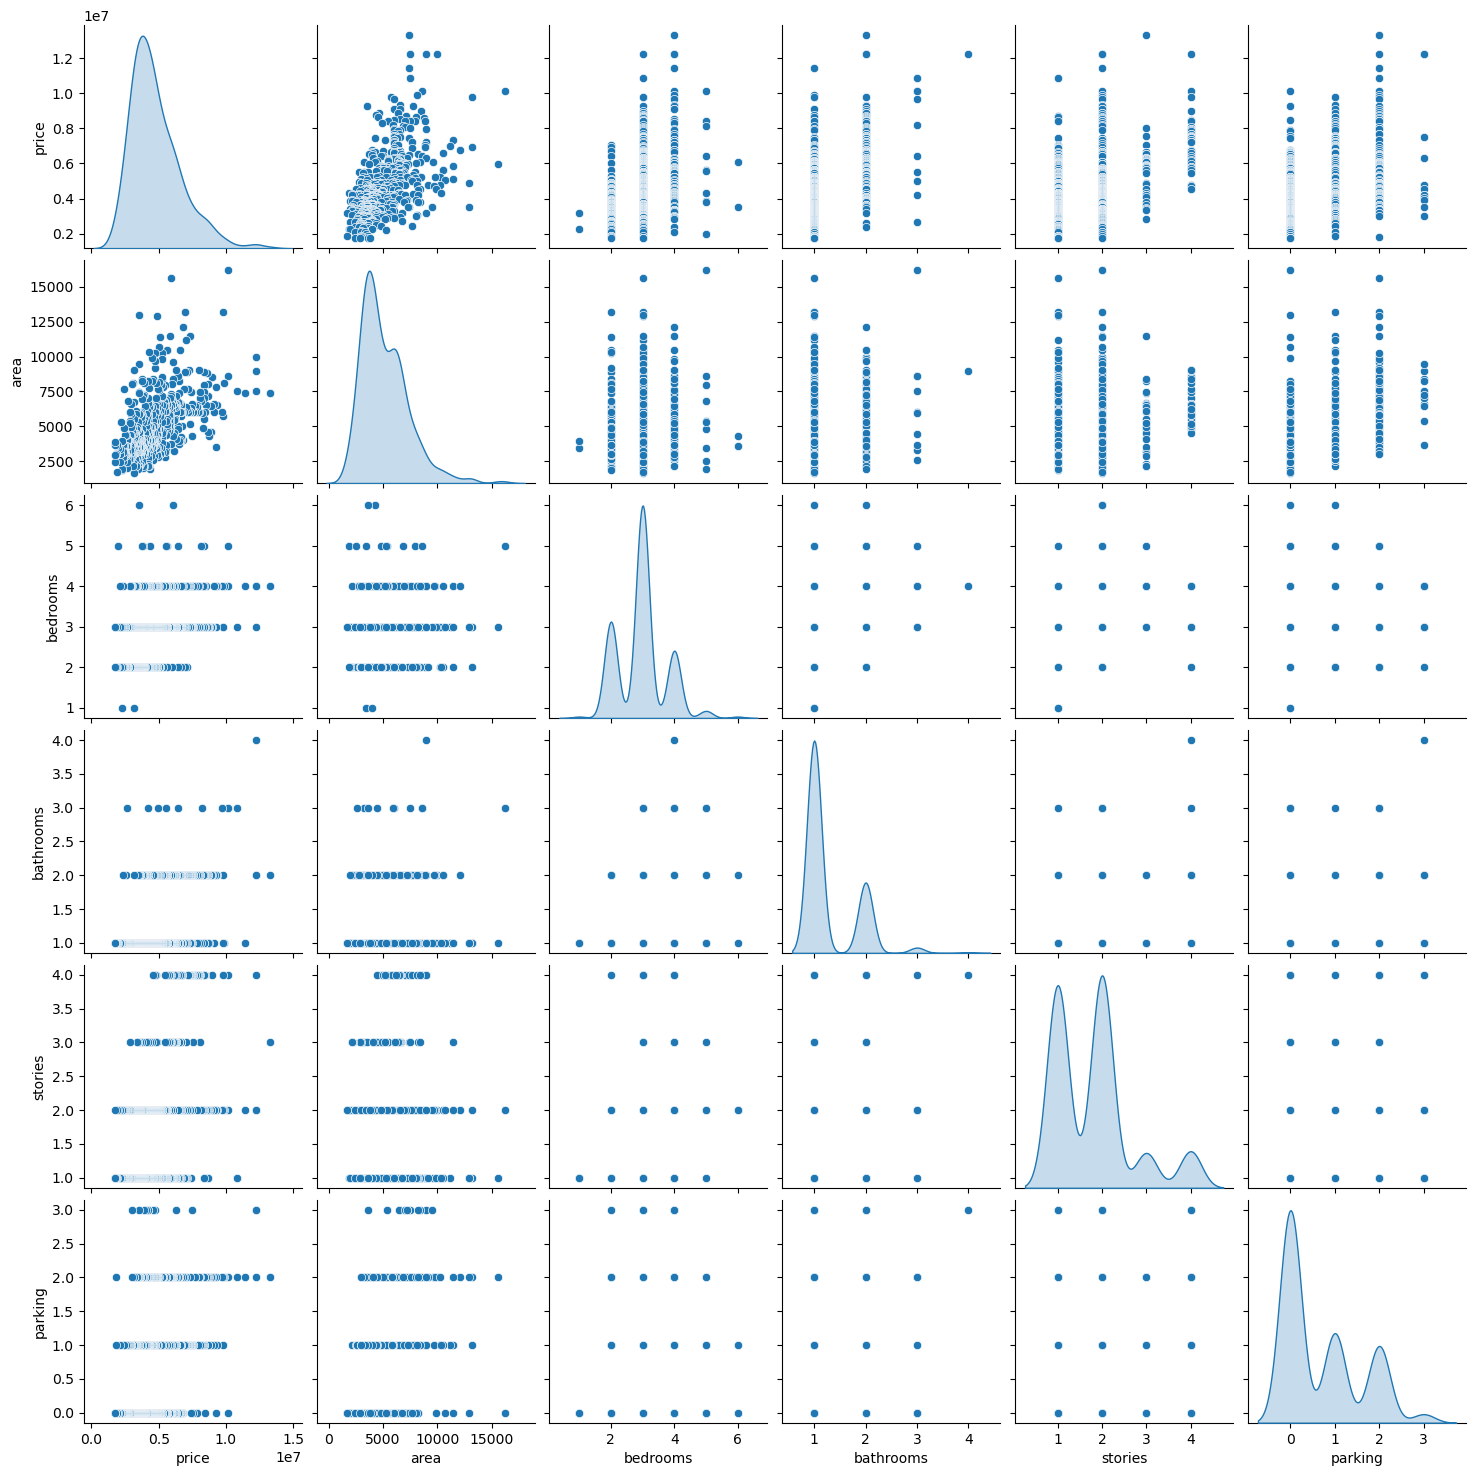

In [24]:
sb.pairplot(raw_data, kind='scatter',diag_kind='kde', palette = "husl")

### 3. What is the correlation between Price & Area ?

In [25]:
data[['price','area']].corr()

,price,area
price,1.000000,0.535997
area,0.535997,1.000000


### 4. What is the distribution of House Prices ?

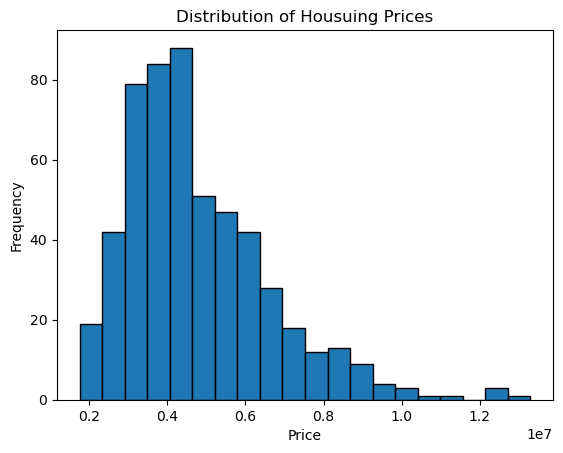

In [26]:
plt.hist(data['price'], bins = 20, edgecolor = 'black')
plt.title('Distribution of Housuing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [27]:
data.head()

,price,area,bedrooms,bathrooms,parking,mainroad_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,2,1,0,0,1,0,0
1,12250000,8960,4,4,3,1,0,0,1,0,0
2,12250000,9960,3,2,2,1,1,0,0,1,0
3,12215000,7500,4,2,3,1,1,0,1,0,0
4,11410000,7420,4,1,2,1,1,0,1,0,0


### 5. What is the distribution of Area ?

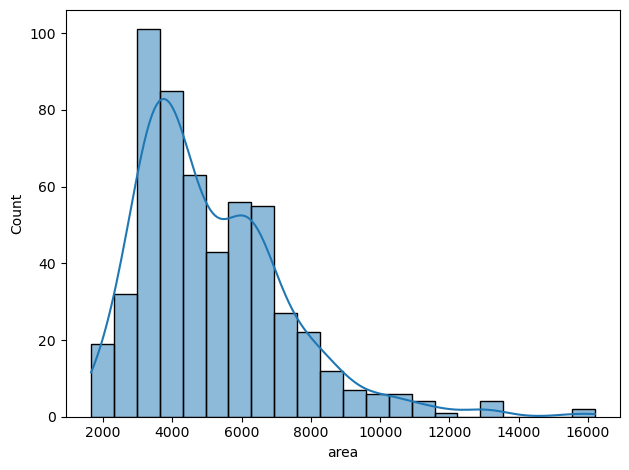

In [28]:
sb.histplot(x='area', data=data, label='Area', multiple='stack', element='bars', kde=True)
plt.tight_layout()
plt.show()

### 6. What are the relationships between all the numerical features ? 

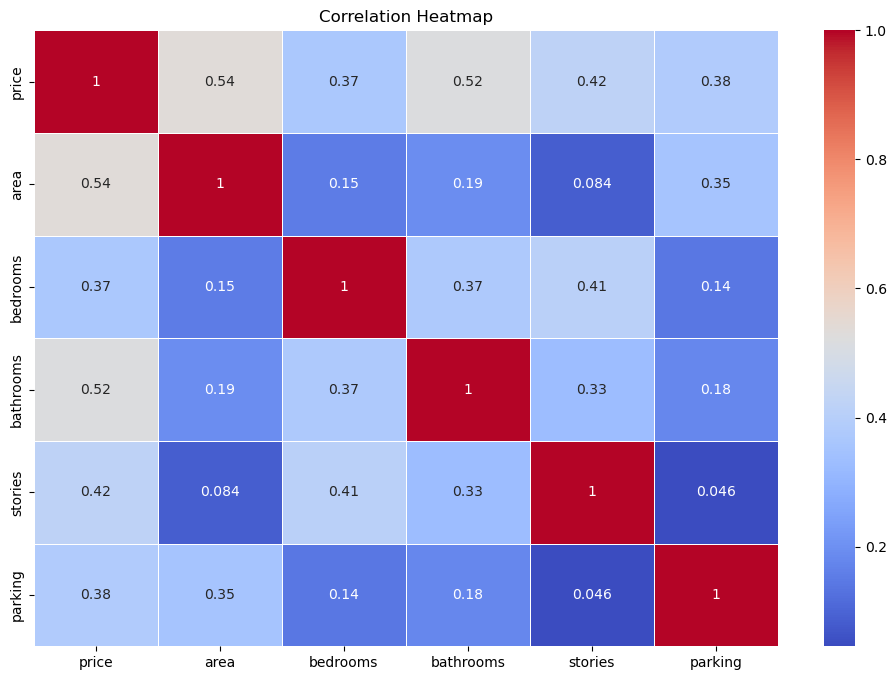

In [29]:
# Select only numeric columns for correlation analysis
numeric_df = raw_data.select_dtypes(include=[np.number])


correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### 7. What is the distributions of Price & Area based on bedrooms ?

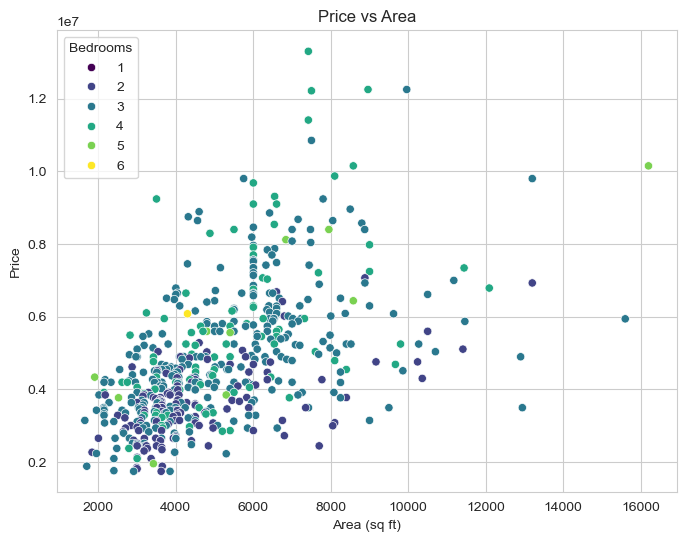

In [30]:
sb.set_style("whitegrid")

plt.figure(figsize=(8, 6))
sb.scatterplot(x='area', y='price', data=data, hue='bedrooms', palette='viridis')
plt.title('Price vs Area')
plt.xlabel('Area (sq ft)')
plt.ylabel('Price')
plt.legend(title='Bedrooms')
plt.show()

### 8. What is the distrubution of bedrooms?

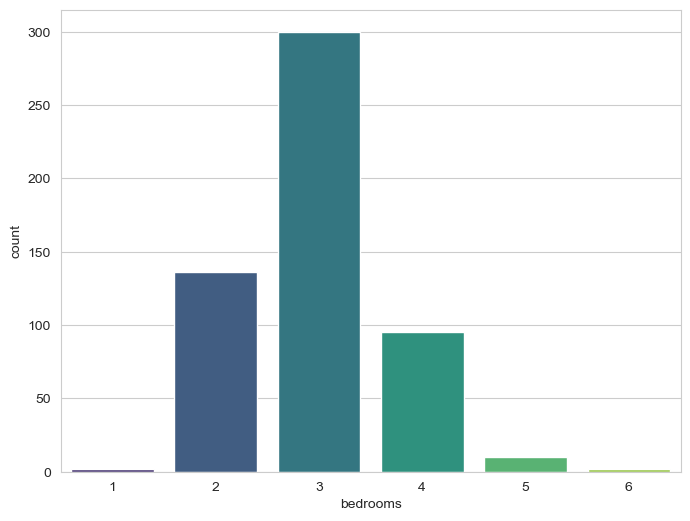

In [31]:
plt.figure(figsize=(8, 6))
sb.countplot(data=data, x = 'bedrooms', palette = 'viridis')
plt.show()

### 9. What is the distrubution of bathrooms?

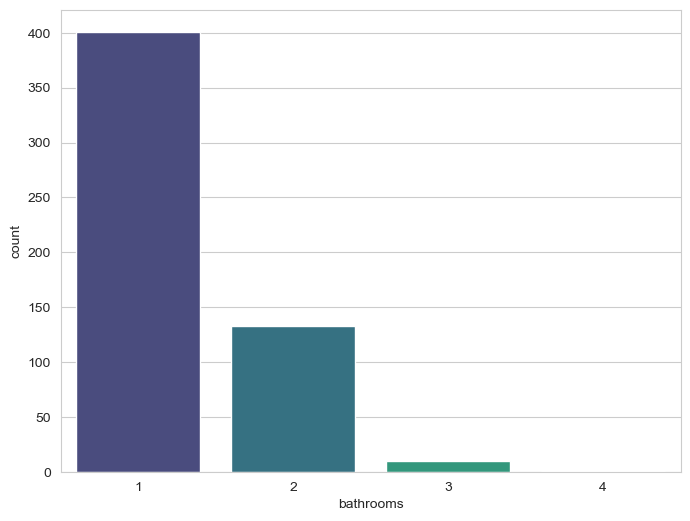

In [32]:
plt.figure(figsize=(8, 6))
sb.countplot(data=data, x = 'bathrooms', palette = 'viridis')
plt.show()

### 10. What is the distibutions of Area & Price alone?

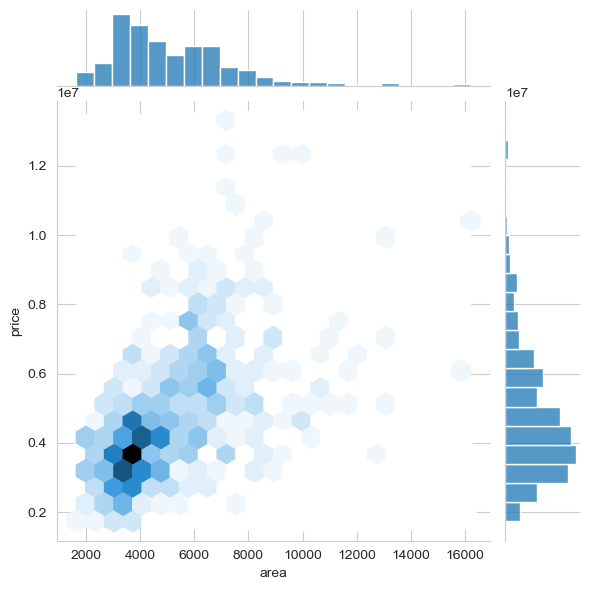

In [33]:
sb.jointplot(x='area',y='price',data=data, kind='hex') 
plt.show()

In [34]:
data.head()

,price,area,bedrooms,bathrooms,parking,mainroad_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,2,1,0,0,1,0,0
1,12250000,8960,4,4,3,1,0,0,1,0,0
2,12250000,9960,3,2,2,1,1,0,0,1,0
3,12215000,7500,4,2,3,1,1,0,1,0,0
4,11410000,7420,4,1,2,1,1,0,1,0,0


In [35]:
data.rename(columns={'furnishingstatus_semi-furnished' : 'furnishingstatus_semi_furnished'})

,price,area,bedrooms,bathrooms,parking,mainroad_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,furnishingstatus_semi_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,2,1,0,0,1,0,0
1,12250000,8960,4,4,3,1,0,0,1,0,0
2,12250000,9960,3,2,2,1,1,0,0,1,0
3,12215000,7500,4,2,3,1,1,0,1,0,0
4,11410000,7420,4,1,2,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,2,1,1,0,0,0,1
541,1767150,2400,3,1,0,0,0,0,0,1,0
542,1750000,3620,2,1,0,1,0,0,0,0,1
543,1750000,2910,3,1,0,0,0,0,0,0,0


### Input Output Split

In [36]:
indep_x = data.drop('price',axis=1)
dep_y = data['price']

In [37]:
indep_x.columns
indep_x.rename(columns={'furnishingstatus_semi-furnished': 'furnishingstatus_semi_furnished'}, inplace=True)

### Train Test Split

In [38]:
x_train,x_test,y_train,y_test = train_test_split(indep_x,dep_y,test_size=0.2,random_state=0)
y_train


542    1750000
496    2695000
484    2870000
507    2590000
252    4515000
        ...   
70     6790000
277    4305000
9      9800000
359    3710000
192    5040000
Name: price, Length: 436, dtype: int64

### Feature Scaling

sc = StandardScaler()
x_train = sc.fit(x_train)
x_test = sc.transform(x_test)

### Linear Regression

In [39]:
regressor = LinearRegression()
regressor.fit(x_train,y_train)


LinearRegression()

In [40]:
weight = regressor.coef_
weight

array([ 2.84522189e+02,  3.15932226e+05,  1.16164751e+06,  1.65782314e+05,
        7.26754044e+05,  3.69343430e+05,  1.14871408e+06,  1.05463942e+06,
       -1.91904986e+05, -6.00520962e+05])

In [41]:
Bias = regressor.intercept_
Bias

-78489.26186181419

In [42]:
y_pred = regressor.predict(x_test)

In [43]:
R2_score = r2_score(y_test,y_pred)
print('LinearRegression -> R2_score :', R2_score) 

LinearRegression -> R2_score : 0.6258090576878408


### Support Vector Machine

In [44]:
regressor = SVR(kernel = 'linear')
regressor.fit(x_train,y_train)

SVR(kernel='linear')

In [45]:
y_pred = regressor.predict(x_test)

In [46]:
R2_score = r2_score(y_test,y_pred)
print('Support Vector Machine -> R2_score :', R2_score) 

Support Vector Machine -> R2_score : 0.2935467336470645


### Decision Tree Regressor

In [47]:
regressor = DecisionTreeRegressor(criterion='squared_error', splitter='best', max_features='sqrt', random_state = 0)
regressor.fit(x_train,y_train)

DecisionTreeRegressor(max_features='sqrt', random_state=0)

In [48]:
y_pred = regressor.predict(x_test)

In [49]:
R2_score = r2_score(y_test,y_pred)
print('Decision Tree Regressor -> R2_score :', R2_score) 

Decision Tree Regressor -> R2_score : 0.11785567649750794


### Random Forest Regressor

In [50]:
regressor = RandomForestRegressor(n_estimators = 10, criterion = 'absolute_error', max_features = 'sqrt', random_state=0)
regressor.fit(x_train,y_train)

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=10, random_state=0)

In [51]:
y_pred = regressor.predict(x_test)

In [52]:
R2_score = r2_score(y_test,y_pred)
print('Random Forest Regressor -> R2_score :', R2_score)

Random Forest Regressor -> R2_score : 0.5765185954308023


### XGBRegressor

In [53]:
regressor = XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate=0.1)
regressor.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
y_pred = regressor.predict(x_test)

In [55]:
R2_score = r2_score(y_test,y_pred)
print('XGBRegressor -> R2_score :', R2_score)

XGBRegressor -> R2_score : 0.6233220344984307


In [56]:
x_train.columns

Index(['area', 'bedrooms', 'bathrooms', 'parking', 'mainroad_yes',
       'basement_yes', 'hotwaterheating_yes', 'airconditioning_yes',
       'furnishingstatus_semi_furnished', 'furnishingstatus_unfurnished'],
      dtype='object')

The accuracy is below average so this dataset is not considered the Best.

### Save the Model

In [57]:
filename = 'Finalized_HousePricePrediction_Model.sav'
pickle.dump(regressor,open(filename,'wb'))

In [58]:
user_input = [[2000, 3, 2, 1, 1, 0, 0, 1, 1, 0]]

In [64]:
input_values = np.array([[2000, 3, 2, 1, 1, 0, 0, 1, 1, 0]])

In [65]:
loaded_model = pickle.load(open('Finalized_HousePricePrediction_Model.sav','rb'))
Prediction = loaded_model.predict(input_values)

In [68]:
Prediction[0]

5513165.5